# <center> An Introduction to Deep Learning With Python <center/>

### [8.2] DeepDream in Keras
Prof. Yuzo Iano

pgs: 281 - 

#### Loading the pretrained Inception V3 model

In [4]:
from keras.applications.inception_v3 import InceptionV3
from keras import backend as K

In [6]:
K.set_learning_phase(0)
model = InceptionV3(weights = 'imagenet', include_top = False)

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 14s 0us/step


In [7]:
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5
}

#### Defining the loss to be maximized

In [8]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

#### Gradient-ascent process

In [9]:
dream = model.input
grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

In [10]:
def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

In [11]:
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at ', i, ':', loss_value)
        x += step * grad_values
    return x

#### Auxilliary functions

In [13]:
import scipy
from keras.preprocessing import image

In [14]:
def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)

In [15]:
def save_img(img, fname):
    pil_image = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_image)

In [16]:
def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

In [17]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

#### Running gradient ascent over different successive scales

In [18]:
import numpy as np

step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20
max_loss = 10
base_image_path = 'grama.jpg'
img = preprocess_image(base_image_path)
original_shape = img.shape[1:3]
succesive_shapes = [original_shape]

for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i))
                  for dim in original_shape])
    succesive_shapes.append(shape)

succesive_shapes = succesive_shapes[::-1]

original_img = np.copy(img)
shrunk_original_img = resize_img(img, succesive_shapes[0])

for shape in succesive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scales_' + str(shape) + '.png')
    
save_img(img, fname='final_dream.png')

Processing image shape (326, 326)
...Loss value at  0 : 1.2852011
...Loss value at  1 : 1.8864646
...Loss value at  2 : 2.5252922
...Loss value at  3 : 3.154289
...Loss value at  4 : 3.8254318
...Loss value at  5 : 4.517752
...Loss value at  6 : 5.1965256
...Loss value at  7 : 5.8220005
...Loss value at  8 : 6.468895
...Loss value at  9 : 7.0911365
...Loss value at  10 : 7.7676725
...Loss value at  11 : 8.401022
...Loss value at  12 : 9.07316
...Loss value at  13 : 9.727113


C:\Users\pablo\Python\envs\DAVID\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pablo\Python\envs\DAVID\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Processing image shape (457, 457)
...Loss value at  0 : 2.6484818
...Loss value at  1 : 3.9946883
...Loss value at  2 : 5.255889
...Loss value at  3 : 6.444748
...Loss value at  4 : 7.5588536
...Loss value at  5 : 8.785267
Processing image shape (640, 640)
...Loss value at  0 : 3.5263147
...Loss value at  1 : 6.0270605
...Loss value at  2 : 9.786003


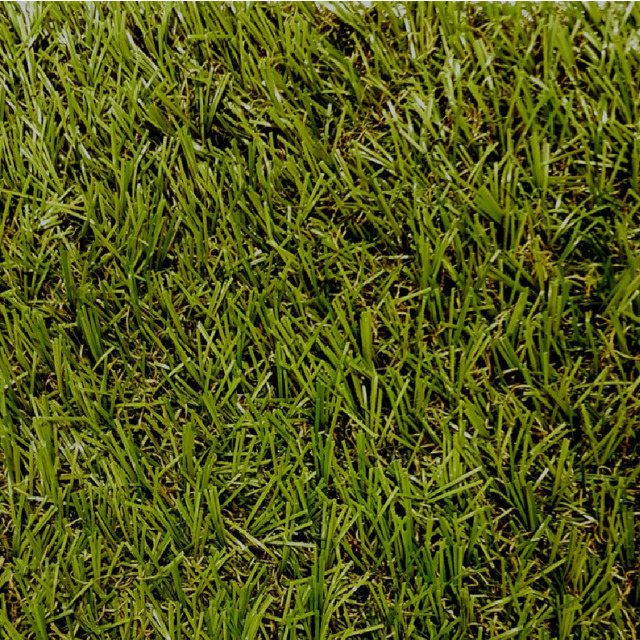

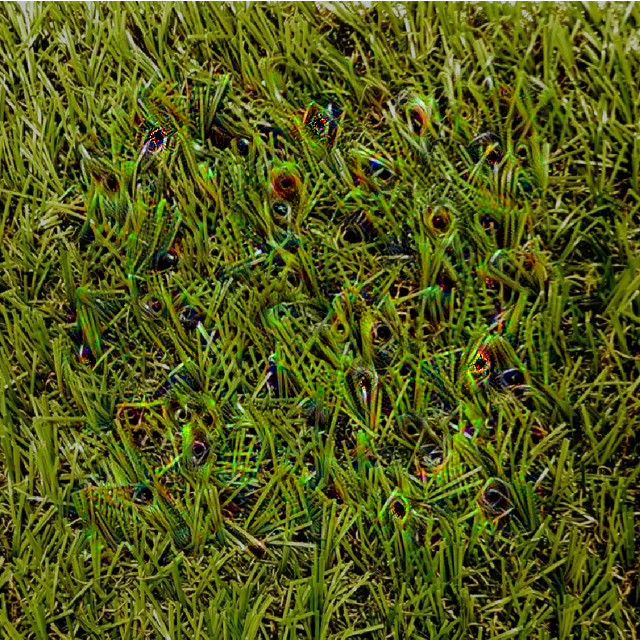

In [21]:
from IPython.display import Image
x = Image(filename='grama.jpg', height=400, width=400)
y = Image(filename='final_dream.png', height=400, width=400)
display(x, y)

In [22]:
step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20
max_loss = 10
base_image_path = 'ex2.jpg'
img = preprocess_image(base_image_path)
original_shape = img.shape[1:3]
succesive_shapes = [original_shape]

for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i))
                  for dim in original_shape])
    succesive_shapes.append(shape)

succesive_shapes = succesive_shapes[::-1]

original_img = np.copy(img)
shrunk_original_img = resize_img(img, succesive_shapes[0])

for shape in succesive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scales_' + str(shape) + '.png')
    
save_img(img, fname='final_dream.png')

C:\Users\pablo\Python\envs\DAVID\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Processing image shape (234, 351)
...Loss value at  0 : 1.9095844
...Loss value at  1 : 2.4089239
...Loss value at  2 : 3.105619
...Loss value at  3 : 3.7721012
...Loss value at  4 : 4.5242815
...Loss value at  5 : 5.2202954
...Loss value at  6 : 5.8730936
...Loss value at  7 : 6.581296
...Loss value at  8 : 7.1658206
...Loss value at  9 : 7.7332554
...Loss value at  10 : 8.296839
...Loss value at  11 : 8.777473
...Loss value at  12 : 9.223952
...Loss value at  13 : 9.648778


C:\Users\pablo\Python\envs\DAVID\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Processing image shape (327, 491)
...Loss value at  0 : 3.0115323
...Loss value at  1 : 4.412323
...Loss value at  2 : 5.4962444
...Loss value at  3 : 6.409892
...Loss value at  4 : 7.2163553
...Loss value at  5 : 7.989553
...Loss value at  6 : 8.698456
...Loss value at  7 : 9.352154
...Loss value at  8 : 9.979662
Processing image shape (459, 688)
...Loss value at  0 : 3.0647936
...Loss value at  1 : 4.3328824
...Loss value at  2 : 5.38324
...Loss value at  3 : 6.3031907
...Loss value at  4 : 7.191517
...Loss value at  5 : 7.9933796
...Loss value at  6 : 8.735939
...Loss value at  7 : 9.444316


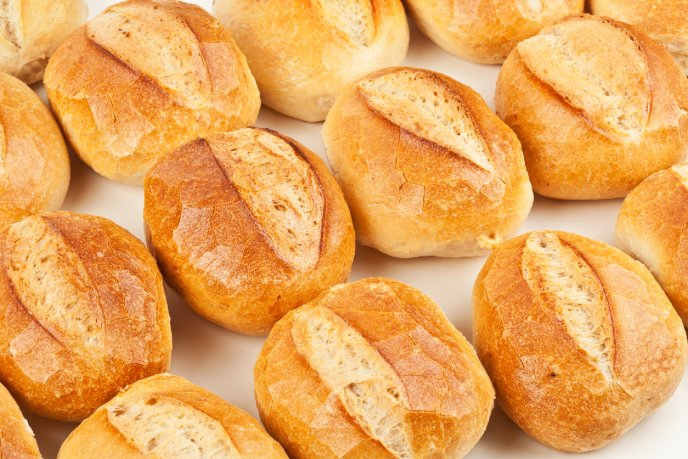

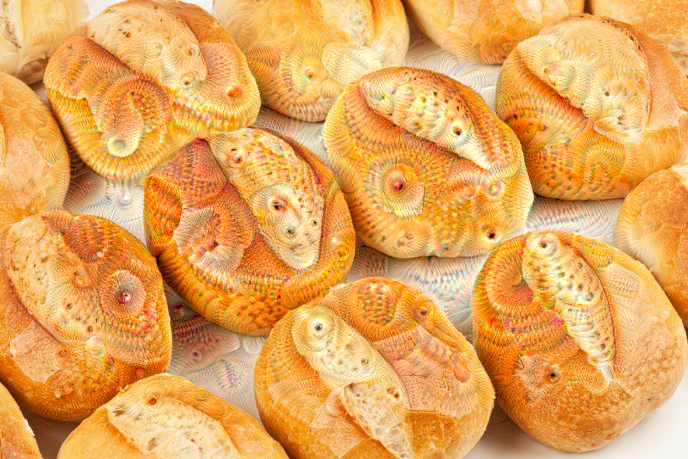

In [23]:
from IPython.display import Image
x = Image(filename='ex2.jpg', height=400, width=400)
y = Image(filename='final_dream.png', height=400, width=400)
display(x, y)

###### Pablo Minango
* pablodavid218@gmail.com 